# Factor Tensor Network Message Passing 

This Jupyter Notebook introduces the process of FTNMP, which is mainly divided into:
* Region partitioning, merging and extending the region to the local subsystem
* FTNMP iterative process
* Entropy calculation


In [1]:
import torch as tc
import graph_generate as gg
import contract_exact as ce
import time
import TNBP
import EntropyBP as EBP
import EntropyFTNMP as EFT
import get_regions_new as grn
import networkx as nx
import itertools as it
import copy
import picture
import nx_test as nxt

## Region partitioning, merging and extending the region to the local subsystem

The graph is partitioned into suitable regions, aiming to identify strongly interconnected structures and to ensure that the regions either share only one common variable node or are connected to other regions by edges through a variable node. The regions will be pinched into aggregated factor nodes in order to obtain the tree-like structure. 

Firstly we generate a subgraph Region of G, which satisfies that the shortest loop cross the Region and G\Region is longer than a parameter R. Subsequently, we refine the regions by adjusting their boundaries and merging some of them to form clusters of closely correlated node. We first demonstrate this on a graph with fewer points and low constraint density. For clarity, we do not show outliers in the diagram.

The following is the first step of region partitioning. This section consists of three procedures:

* Remove isolated nodes or nodes with a single neighbor from the graph G.
* Generate a subgraph Region(R) from the given edge e on the corresponding graph G.
* Generate a list of subgraphs (Regions) from the given graph G. 




In [2]:
def cut(G,nodes = False):
    """Remove isolated nodes or nodes with a single neighbor from the graph G.
    If nodes are specified, only those nodes are considered for removal; otherwise, all nodes are processed.
    
    Parameters
    ----------
    G : nx.Graph
        The input graph from which nodes are to be removed.
    nodes : list of int, optional
        A list of nodes to be considered for removal. If not provided, all nodes in the graph are considered.
    
    Returns
    -------
    G_loop : nx.Graph
        A copy of the input graph with the specified nodes (or all nodes) removed if they are isolated or have only one neighbor.
    """
    G_loop = copy.deepcopy(G)
    if nodes != False:
        for i in nodes:
            if i in G_loop:
                if len(G_loop[i]) == 0:
                    G_loop.remove_node(i)
                elif len(G_loop[i]) == 1:
                    j = list(G_loop[i])[0]
                    G_loop.remove_node(i)
                    while len(G_loop[j]) == 1:
                        k = list(G_loop[j])[0]
                        G_loop.remove_node(j)
                        j = k
    else:
        nodes = list(G_loop.nodes())
        for i in nodes:
            if i in G_loop:
                if len(G_loop[i]) == 0:
                    G_loop.remove_node(i)
                elif len(G_loop[i]) == 1:
                    j = list(G_loop[i])[0]
                    G_loop.remove_node(i)
                    while len(G_loop[j]) == 1:
                        k = list(G_loop[j])[0]
                        G_loop.remove_node(j)
                        j = k
    return G_loop

def Region_generator(G,e,R):
    """Generate a subgraph Region(R) from the given edge e on the corresponding graph G, 
    which satisfies that the shortest loop cross the Region and G\Region is longer than R (cross means share more than 1 edge here).
    
    Parameters
    ----------
    G : nx.Graph
        The complete graph.
    e : tuple of int
        The beginning edge, it should be an element of list(G.edges()).
    R : int

    Returns
    -------
    Region : nx.Graph
        The subgraph.
    """
    Region = nx.Graph()
    G_environment = copy.deepcopy(G)
    G_environment.remove_edge(e[0],e[1])
    Region.add_edge(e[0],e[1])
    boundary = list(e)
    edge_new = True
    l = 2

    while edge_new:
        edge_new = False
        new_path = []

        for i in range(1,l):
            for j in range(i):
                n1 = boundary[i]
                n2 = boundary[j]
                if nx.has_path(G_environment,n1,n2):
                    shortest_paths_out = list(nx.all_shortest_paths(G_environment, n1, n2))
                    l_shortest_paths_in = nx.shortest_path_length(Region, n1, n2)
                    if len(shortest_paths_out[0]) + l_shortest_paths_in <= R+1:
                        edge_new = True
                        new_path += shortest_paths_out
                                    
        outnode = set()
        for path in new_path:
            outnode.update(path)
            for node_id in range(len(path)-1):
                if not Region.has_edge(path[node_id],path[node_id+1]):
                    Region.add_edge(path[node_id],path[node_id+1])
                    G_environment.remove_edge(path[node_id],path[node_id+1])

        if edge_new:
            boundary = []
            for node in outnode: 
                if len(Region[node])<len(G[node]):
                    boundary.append(node)
        l = len(boundary)
        
        if l < 2:
            break
        
    return Region

def get_Regions(G,R):
    """Generate a list of subgraphs (Regions) from the given graph G. 
    Each Region is generated by iteratively applying the Region_generator function on the edges of G 
    and removing edges from G after each Region is created.
    
    Parameters
    ----------
    G : nx.Graph
        The input graph from which Regions are to be generated.
    R : int
        A parameter that controls the size or structure of the Regions generated.
    
    Returns
    -------
    Regions :  An instance of the Graph class from the networkx library
        A instance of subgraphs (Regions) generated from the input graph G.
    """
    G = cut(G)
    G_remain = copy.deepcopy(G)
    Regions = []
    edges = list(G.edges())
    for e in edges:
        if G_remain.has_edge(e[0],e[1]):
            g = Region_generator(G_remain,e,R)
            G_remain.remove_edges_from(list(g.edges())) 
            if len(g) > 2:
                Regions.append([g])
            G_remain = cut(G_remain,list(g))
    return Regions

print('Initially region division function definition complete')


Initially region division function definition complete


 Regions: [[100, 10, 178, 32, 172, 7, 4, 145], [94, 101, 46, 109, 59, 120, 21, 173, 20, 151, 111, 22, 146, 113, 17, 171, 71, 41, 128], [94, 116, 53, 169, 33, 160], [46, 114, 65, 135, 118, 45, 123, 62, 167, 64, 131, 90, 175, 179, 29, 141, 87, 136, 79, 164, 13], [4, 108, 34, 143, 31, 154, 176, 3, 112, 29], [34, 129, 78, 133, 75, 140], [3, 158, 57, 165], [96, 119, 51, 161], [84, 127, 28, 163]] 
 The graph is initially divided into 9 region(s) .


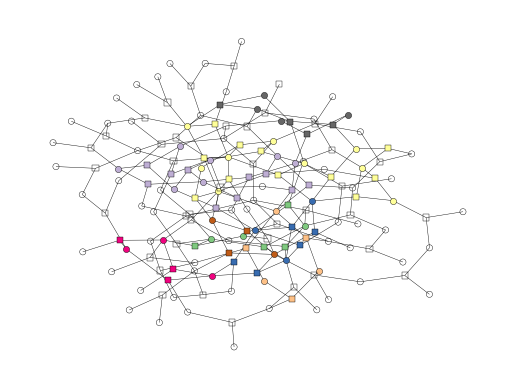

In [3]:
R = 6
clauses, tendencies = gg. random_k_sat_graph(100,0.8,3,2)
G_fac,max_item =gg.G_generator_fac(clauses)
regions = get_Regions(G_fac,R)
Regions = [list(re[0]) for re in regions]
print(' Regions:', Regions,'\n','The graph is initially divided into',len(Regions),'region(s) .')
picture.draw_custom_graph(G_fac,Regions,max_item,len(Regions))


The following is the second step —— merging and extending the region to the local subsystem for entropy computing. Considering the partitioning in the first step, there may be some factor nodes appearing at the edge. In fact, in the spin glass model, the factor nodes are only representations of three-body interactions and are not real spins. So the first step in this procedure is to incorporate the neighbors of the edge factor node (that is, the variable node) into the local subsystems. This slightly unnatural approach prevents the entire graph from being segmented when the constraint density is high, but introduces some overlap. Because three-body interactions are not expected to be separated when we compute the entropy (although the existence of factor nodes in overlap does not mean that three-body interactions are necessarily separated), we do not want overlap to contain factor nodes. So if there are factor nodes in the overlap between the two regions, we combine the two regions into one. At the same time, the process of including variable nodes and merging is an extension of the region, which may result in a situation where two variable nodes connected to the same factor node are on the edge. The factor nodes in this case should also be included in the local subsystems.

<span style="font-size:12px">Although the concept of G_env in the coresponding article is not explicitly mentioned in this program, the behavior of the merged factor node is searched in G_env from parts of the graph except regions.</span>

In [4]:
def get_regions(G,clauses,max_item,R_region):
    devides = []
    ignore_var_node=[]        #ignore_var_node stores the variable nodes that appear inside the region. 
                              #These nodes, along with factor nodes, are merged into a single point, hence they are "ignorable."
    region_info = []
    regions = get_Regions(G,R_region)
    regions = [list(re[0]) for re in regions]
    
    for region in regions:
        devide =  list(region)
        devide_copy = copy.deepcopy(devide)
    
        for node in devide_copy: 
            if node > max_item:
                nei = list(G.neighbors(node))
                devide = list(set(devide+nei))
               
        devides.append(sorted(devide))

    devides_one_dim = list(it.chain(*devides))
    devides = devides+[[i] for i in range(max_item+1,max_item+1+len(clauses)) if i not in devides_one_dim]
    devides = grn.intersection_between_two_regions(G,devides,clauses,max_item)
    devides = [devide for devide in devides if len(devide)>1]
    devides = grn.cheke_factor_node(G,devides,clauses,max_item)
    
    ignore_var_node =[]
    for devide_id in range(len(devides)):
        devide = devides[devide_id]
        region_info_ele = []
        for noded in devide:
            if len(set(list(G.neighbors(noded)))&set(devide)) > 1: 
                ignore_var_node.append(noded)
                region_info_ele.append(noded)
        region_info.append(region_info_ele)
    ignore_var_node = set(ignore_var_node)
    ignore_var_node = [ivn for ivn in set(ignore_var_node) if ivn<=max_item]
    devides_one_dim = list(it.chain(*devides))
    lengh = len(devides)

    for var_node in range(max_item+1):
        if var_node not in ignore_var_node:
            nei = list(G.neighbors(var_node))
            devides.append([var_node]+nei)
    
    for fac_node in range(max_item+1,len(clauses)+max_item+1):
        if fac_node not in devides_one_dim:
            nei = list(G.neighbors(fac_node))
            devides.append([fac_node]+nei)
    return devides,region_info,ignore_var_node,lengh

print('Finally region division function definition complete')

Finally region division function definition complete


 local subsystem: [[32, 97, 4, 100, 7, 10, 11, 75, 172, 46, 145, 178, 117], [128, 131, 135, 136, 9, 13, 141, 16, 17, 146, 20, 21, 22, 23, 151, 29, 31, 164, 167, 40, 41, 171, 173, 46, 45, 175, 177, 50, 179, 56, 57, 59, 62, 64, 65, 69, 71, 74, 79, 85, 86, 87, 89, 90, 91, 94, 101, 104, 107, 109, 111, 113, 114, 115, 118, 120, 123], [160, 33, 67, 5, 169, 77, 116, 53, 94], [34, 3, 4, 26, 108, 143, 112, 176, 19, 154, 29, 30, 31], [129, 34, 98, 133, 6, 75, 140, 78, 52], [3, 165, 39, 16, 57, 158], [96, 161, 79, 51, 20, 119], [163, 11, 84, 28, 62, 127], [0, 152, 155], [1, 137], [2, 149, 170], [5, 149, 153, 160], [6, 140], [8, 148], [11, 100, 163], [12, 174], [14, 148, 156], [15], [16, 150, 165, 173], [18, 168], [19, 154, 162], [24, 138], [25], [26, 134, 143], [27, 103], [30, 112], [35, 122], [36, 157], [37], [38, 130], [39, 102, 130, 134, 158], [42], [43, 137, 157, 168], [44, 125, 155], [47, 106, 150], [48, 110], [49, 153], [50, 105, 167], [52, 133], [54, 110, 144], [55, 105], [58, 124, 126, 174

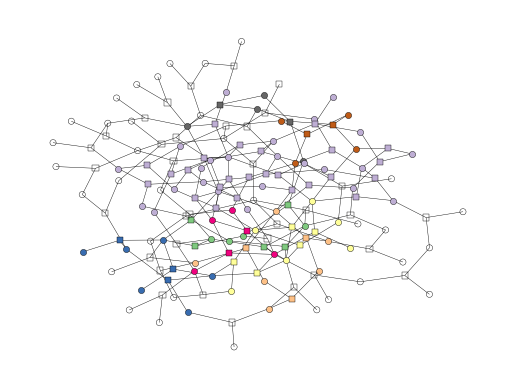

In [5]:
devides,region_info,single_list,lengh = get_regions(G_fac,clauses,max_item,R)
print(' local subsystem:',devides,'\n','The graph is finally divided into',lengh,'local subsystem(s).')
picture.draw_custom_graph(G_fac,devides,max_item,lengh)

## FTNMP iterative process

In FTNMP, the region participating in the iteration is the region of the local subsystems with leaf variable nodes clipped, and the leaf variable nodes with degree greater than 1 connect the region to other factor nodes. In the process of iteration, their neighborhood is their immediate neighbor.

In general, we want regions to be connected by an intermediate variable node, or the intersection of regions to have only one variable node. In this way, the divided area is more easily approximated as a tree structure. But in practice, if R is chosen appropriately, we can accept the accuracy impact of having multiple variable nodes at overlaps between regions. When iterating over the messages at overlaps, we treat the region that receives the messages as a direct product state, passing through the boundary of the region that passes the messages and contracting with it.
Before the iterative of FTNMP, let's determine some information about the graph to be used

* The neighborhood  and boundary of each point is generated using the region of the removed leaf node. 

* The neighborhood of points in a region is the set of points in their region.

* The neighborhood of variable nodes on the region boundary is the intersection of its region. 

* The neighborhood of the leaf variable nodes are its immediate neighbors.

<span style="font-size:12px">~grn.region_info_change is used to change the format of region_info since the "leaf nodes" of regions and single factor nodes are regarded as special region</span>

In [6]:
'''Look for the neighborhood of each situation and adjust the format of regions. '''
devides,region_info,single_list,lengh = get_regions(G_fac,clauses,max_item,R)
Nv,boundaries = grn.devides_to_Nv(G_fac,devides,region_info)
region_info,region_bound = grn.region_info_change(G_fac,clauses,region_info,max_item,single_list)
devide_bound,degree_node = grn.devides_others(G_fac,devides)

'''Look for the overlaps. '''
_, _, direct_products_info,_ =nxt.cluster_edges_generate_new(G_fac,max_item,devides,devide_bound)
direct_products = [sorted(direct_products_info[i][2]) for i in range(len(direct_products_info)) if len(direct_products_info[i][2])>=2 and min(direct_products_info[i][0],direct_products_info[i][1])<=len(region_info)]
print(' The neighborhoods of nodes:',Nv,'\n','The boundraies of nodes:',boundaries,'\n','The regions of the graph:',region_info,'\n','The overlaps of the graph:',direct_products, '\n','The region boundaries of the graph:',region_bound)

 The neighborhoods of nodes: [[152, 155, 0], [137, 1], [149, 170, 2], [34, 3, 4, 165, 108, 143, 112, 176, 147, 148, 57, 154, 29, 158, 31], [3, 4, 7, 10, 143, 145, 154, 29, 31, 32, 34, 172, 176, 178, 75, 97, 100, 103, 108, 112, 117], [149, 153, 160, 5], [140, 6], [32, 97, 100, 4, 7, 10, 139, 172, 75, 144, 145, 178, 117], [148, 8], [128, 131, 135, 136, 9, 13, 141, 17, 146, 20, 21, 22, 23, 151, 29, 164, 167, 40, 41, 171, 173, 46, 45, 175, 177, 179, 56, 57, 59, 62, 64, 65, 71, 79, 87, 90, 91, 94, 101, 104, 107, 109, 111, 113, 114, 115, 118, 120, 123], [32, 97, 100, 4, 7, 10, 75, 172, 145, 178, 147, 117], [100, 163, 11], [174, 12], [128, 131, 135, 136, 9, 138, 141, 13, 17, 146, 20, 21, 22, 23, 151, 29, 164, 167, 40, 41, 171, 173, 46, 45, 175, 177, 179, 56, 57, 59, 62, 64, 65, 71, 79, 87, 90, 91, 94, 101, 104, 107, 109, 111, 113, 114, 115, 118, 120, 123], [148, 156, 14], [15], [150, 165, 173, 16], [128, 131, 135, 136, 9, 13, 142, 141, 17, 146, 20, 21, 22, 23, 151, 29, 164, 167, 40, 41, 171, 

In [7]:
def FTNMP(G_fac,Nv,boundaries,clauses,tendencies,interactions,max_item,region_info,region_bound,device):
    """
    Perform a tensor network belief propagation (the message here is equal to belief --the probapalities of nodes satisfy the constraints) 
    algorithm for a 3-SAT problem with interaction.

    Parameters:
    G_fac (nx.Graph): The factor graph representing the problem.
    Nv (list of lists): List of nodes in the neighborhoods of the corresponding node of index.
    boundaries (list of lists): List of nodes in the boundary of the neighborhoods of the corresponding node of index.
    clauses (list of lists): List of clauses, where each clause is a list of integers representing nodes.
    tendencies (list of lists): List of tendencies for nodes, indicating which tensor positions should be set to zero.
    interactions (list of lists): List of interactions, where each interaction is a list of nodes.
    max_item (int): The maximum node identifier used in the graph.
    region_info (list of lists): List of regions, where each region is a list of node identifiers.
    region_bound (list of lists): List of boundaries, where each region is a list of integers representing nodes in its boundary.
    device (torch.device): The device (CPU or GPU) on which tensors are allocated.

    Returns:
    cavity (torch.Tensor): The updated cavity tensor after the belief propagation.
    converged (bool): `True` if the algorithm converged within the step limit, `False` otherwise.
    egdelist2 (list of lists): The edge list of the factor graph, sorted.
    step (int): The number of steps performed before convergence or reaching the step limit.
    """
    converged = True
    n = G_fac.number_of_nodes()
    step_limit = 1000
    epsilon = 1e-3
    difference_max = tc.tensor([0.0]).to(device)
    damping_factor = 0         #The damping is adjustable in the .
    egdelist2  = [sorted(edge) for edge in G_fac.edges()]
    cavity = (tc.ones(size=(n,n,4))/2).to(device)
    paths = [[[]for w in range(n)] for d in range(n)]
    t1 = time.time()
    for step in range(step_limit):
        first_center_node = -1

        for div_id in range(len(region_info)):
            div = region_info[div_id]
            inner_msg = {}
            for center_node in div:
                first_boundary_node = -1
                neighborhood = Nv[center_node]
                if (len(boundaries[center_node]) != 0 and first_center_node == -1):
                    first_center_node = center_node

                for node in neighborhood:
                    is_inner_msg = TNBP.inner_node(center_node, div_id,region_bound) and not TNBP.inner_node(node, div_id,region_bound)
                    if (node  in inner_msg) and is_inner_msg:
                        cavity[node][center_node] = inner_msg[node]
                        continue
                    if node in boundaries[center_node]:
                        if first_boundary_node == -1:
                            first_boundary_node = node
                        Ne_cavity = list(set(Nv[node]).difference(Nv[center_node]))
                        for interaction in interactions:
                            for adn in interaction:
                                if node == adn:
                                    for adc in interaction:
                                        if adc in Nv[center_node] and adc != adn and adc not in Ne_cavity and adc != center_node  :
                                                Ne_cavity.append(adc)
                                                Ne_cavity = list(set(Ne_cavity))
                        if len(Ne_cavity)!=0:
                            if step > 0 :
                                New_cavity_vec = TNBP.local_contraction(Ne_cavity,clauses,tendencies,cavity,node,max_item,egdelist2,paths[node][center_node],device)
                            else:
                                New_cavity_vec,my_contract = TNBP.local_contraction_begin(G_fac,Ne_cavity,clauses,tendencies,cavity,node,max_item,egdelist2,device)
                                paths[node][center_node]=my_contract
                            temp = damping_factor * cavity[node][center_node] + (1 - damping_factor) * New_cavity_vec
                            temp /= tc.sum(temp)
                            difference = max(abs(temp[0]-cavity[node][center_node][0]), 
                                            abs(temp[1]-cavity[node][center_node][1]),
                                            abs(temp[2]-cavity[node][center_node][2]),
                                            abs(temp[3]-cavity[node][center_node][3]))
                            cavity[node][center_node] = temp
                            if is_inner_msg:
                                inner_msg[node] = temp
                        else:
                            difference =tc.tensor(0.0).to(device) 
                    else:
                        cavity[node][center_node] = tc.tensor([1.0,1.0,0,0]).to(device)
                        cavity[node][center_node] = cavity[node][center_node]/tc.sum(cavity[node][center_node])
                        difference =tc.tensor(0.0).to(device)
                    if center_node == first_center_node and node == first_boundary_node:
                        difference_max = difference
                    elif difference > difference_max:
                        difference_max = difference
        t2 = time.time()
        print("iteration step:",step+1,",   difference:",difference_max.item(),'    time:',t2-t1 )
        if difference_max <= epsilon :
            break   
    if step==step_limit-1:
        print('unconverged') 
        converged = False  
    return cavity ,converged,egdelist2, step+1

device = 'cpu'
'''Iteration of FTNMP'''
cavity ,converged,egdelist, step = FTNMP(G_fac,Nv,boundaries,clauses,tendencies,direct_products,max_item,region_info,region_bound,device)
print('Converge or not:',converged)


iteration step: 1 ,   difference: 0.5     time: 2.3466525077819824
iteration step: 2 ,   difference: 0.2121618390083313     time: 2.8515496253967285
iteration step: 3 ,   difference: 0.10188473761081696     time: 3.356846570968628
iteration step: 4 ,   difference: 0.04385793209075928     time: 3.8588082790374756
iteration step: 5 ,   difference: 0.021034598350524902     time: 4.359510183334351
iteration step: 6 ,   difference: 0.00696912407875061     time: 4.860350131988525
iteration step: 7 ,   difference: 0.0021905899047851562     time: 5.36423397064209
iteration step: 8 ,   difference: 0.0004474520683288574     time: 5.867265939712524
Converge or not: True


## Entropy calculation
The entropy calculation process is divided into three parts.

* Calculate and sum the entropy of the above local subsystems. 

<span style="font-size:12px">Note that a single node is also treated as a special region and is extended as a local subsystem by its immediate neighbors.</span>
* According to the exclusion principle, subtract the entropy corresponding to the overlapping edges between two regions
* According to the exclusion principle, subtract the entropy for overlaps.
    
<span style="font-size:12px">It can be shown that the points at overlaps are variable nodes, so the entropy of overlaps can be reduced to the product of entropy where only one node overlaps. At the same time, it can be shown that if only one point is the common point of d regions, then its influence on entropy is the (d-1) power of the inner product of the messages passed to this point</span>

In [8]:
def Entropy(G_fac,clauses,tendencies,devides,devide_bound,region_info,single_list,cavity,egdelist,max_item,Nv,degree_node,device):
    '''
    Computes the entropy of a system using various clusters and intersections defined in the factor graph.
    ------------
    Parameters:
    - G_fac (Graph): The factor graph where nodes are connected by factors.
    - clauses (list of lists): List of clauses, where each clause is a list of variable nodes.
    - tendencies (list of lists): Tendencies for each clause.
    - devides (list of lists): Decomposed sets of nodes for entropy calculations.
    - devide_bound (list of lists): Boundaries for each decomposition.
    - region_info (list): Information about different regions in the graph.
    - single_list (list): List of single nodes to consider for point-wise entropy calculations.
    - max_item (int): Maximum index value in the graph.
    - Nv (list of lists): List of devides of the corresponding of index.
    - boundaries (list of lists): List of nodes in the boundary of the neighborhoods of the corresponding node of index.
    - degree_node (dict): Dictionary where keys are nodes and values are their degrees.
    - device (torch.device): The device on which to perform tensor operations (e.g., 'cpu' or 'cuda').
    - file (str): Path to the file where results may be saved or used.
    -cavity (torch.Tensor): The updated cavity tensor after the belief propagation.
    -egdelist2 (list of lists): The edge list of the factor graph, sorted.
    ---------
    Returns:
    - entropy (Tensor): The computed entropy of the system.
    '''

    _,edges_info,_,_ =nxt.cluster_edges_generate_new(G_fac,max_item,devides,devide_bound)
    region_info,_ = grn.region_info_change(G_fac,clauses,region_info,max_item,single_list)
    intersections = [sorted(edges_info[i][2]) for i in range(len(edges_info))  ] 
    loges_devides =  EFT.entropies_cluster(G_fac,clauses,tendencies,devides,devide_bound,max_item,Nv,cavity,device)
    print('The entropy of local subsystems is:                                            ',sum(loges_devides).item())
    logs_points = EFT.entropies_point(single_list,G_fac,clauses,tendencies,devides,devide_bound,cavity,egdelist,degree_node,max_item,device)
    print('The entropy influence of nodes which connect multiple local subsystems is:     ',sum(logs_points).item())
    ms = EFT.entropy_intersection(G_fac,intersections,clauses,tendencies,cavity,max_item,Nv,device)
    print('The entropy influence of edges which is the common edge of local subsystems is:',sum(logs_points).item())
    entropy = sum(loges_devides)-sum(logs_points)-sum(ms)
   

    return entropy
entropy_FTNMP =Entropy(G_fac,clauses,tendencies,devides,devide_bound,region_info,single_list,cavity,egdelist,max_item,Nv,degree_node,device)
print('The entropy calculated by FTNMP is:                                             ',entropy_FTNMP.item()) 

The entropy of local subsystems is:                                             26.031963348388672
The entropy influence of nodes which connect multiple local subsystems is:      -18.657489776611328
The entropy influence of edges which is the common edge of local subsystems is: -18.657489776611328
The entropy calculated by FTNMP is:                                              58.30690383911133


## Comparative calculation accuracy

In [9]:
print(clauses)
configrite_number,sgn,T =ce.local_contraction_ds(G_fac,clauses,tendencies,max_item,25,device)
entropy_exact = tc.log(configrite_number)+sgn*tc.log(tc.tensor(2))
print('The entropy calculated by tensor networks exact contracting is:',entropy_exact.item())
print('The error is:', abs(entropy_exact.item()-entropy_FTNMP.item())/entropy_exact.item())
#print('\n')
entropy_BP,_ = EBP.EntropyBP(clauses,tendencies)
print('The entropy calculated by belief propagation is:',entropy_BP.item())
print('The error is:', abs(entropy_BP.item()-entropy_FTNMP.item())/entropy_exact.item())

[[11, 10, 7], [94, 46, 21], [85, 39, 32], [77, 27, 4], [87, 74, 20], [81, 55, 50], [92, 65, 47], [69, 64, 56], [34, 4, 3], [59, 46, 40], [67, 54, 48], [71, 22, 21], [30, 29, 3], [41, 22, 17], [86, 65, 46], [71, 57, 23], [94, 67, 53], [97, 75, 46], [57, 46, 45], [96, 51, 20], [94, 91, 59], [83, 67, 31], [63, 62, 35], [65, 64, 45], [84, 59, 58], [92, 72, 44], [92, 71, 58], [84, 62, 28], [89, 41, 21], [98, 78, 34], [61, 39, 38], [90, 71, 64], [83, 66, 64], [78, 75, 52], [93, 39, 26], [65, 62, 46], [87, 79, 9], [92, 43, 1], [95, 24, 13], [83, 73, 7], [75, 34, 6], [87, 29, 13], [96, 66, 17], [34, 31, 26], [91, 54, 7], [97, 7, 4], [46, 31, 22], [86, 10, 3], [14, 8, 3], [93, 5, 2], [47, 32, 16], [94, 23, 20], [88, 66, 0], [75, 49, 5], [31, 19, 4], [78, 44, 0], [95, 80, 14], [62, 43, 36], [57, 39, 3], [98, 77, 70], [94, 33, 5], [96, 79, 51], [90, 60, 19], [84, 28, 11], [87, 40, 13], [57, 16, 3], [99, 74, 66], [65, 62, 50], [43, 41, 18], [77, 53, 33], [89, 83, 2], [85, 71, 17], [32, 7, 4], [21,

100%|██████████| 2/2 [00:00<00:00, 66.09it/s]


The entropy calculated by tensor networks exact contracting is: 58.30485194732637
The error is: 3.519247054794489e-05
step: 1     difference: tensor(0.4882)     time: 0.03094339370727539
step: 2     difference: tensor(0.4201)     time: 0.06222248077392578
step: 3     difference: tensor(0.1616)     time: 0.09180784225463867
step: 4     difference: tensor(0.0331)     time: 0.12059688568115234
step: 5     difference: tensor(0.0073)     time: 0.15049982070922852
step: 6     difference: tensor(0.0014)     time: 0.18027377128601074
step: 7     difference: tensor(0.0003)     time: 0.21120619773864746
The entropy calculated by belief propagation is: 58.36060333251953
The error is: 0.0009210124306072537
